# MAP Reduce

https://github.com/kyopark2014/langgraph-agent/blob/main/map-reduce-parallel-processing.md

https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

In [ ]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

from langchain_aws import BedrockEmbeddings
embedding_model_id = "amazon.titan-embed-text-v2:0"
bedrock_embedding = BedrockEmbeddings(
    client=boto3_bedrock,
    region_name = bedrock_region,
    model_id = embedding_model_id
) 

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [19]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [20]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [21]:
!pip install -U tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [22]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Map-Reduce"

In [23]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="이미지를 분석하기 위한 서비스에 대해 설명해줘."
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. 

주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 예를 들어 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 나이, 성별 등의 속성을 분석합니다.

이미지 분석 서비스는 클라우드 기반으로 제공되며, API를 통해 애플리케이션에 쉽게 통합할 수 있습니다. 주요 공급업체로는 AWS, Microsoft Azure, Google Cloud 등이 있습니다. 이 서비스를 활용하면 이미지에서 유용한 인사이트를 얻을 수 있어 다양한 산업에서 활용되고 있습니다.

'안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. \n\n주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 예를 들어 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 나이, 성별 등의 속성을 분석합니다.\n\n이미지 분석 서비스는 클라우드 기반으로 제공되며, API를 통해 애플리케이션에 쉽게 통합할 수 있습니다. 주요 공급업체로는 AWS, Microsoft Azure, Google Cloud 등이 있습니다. 이 서비스를 활용하면 이미지에서 유용한 인사이트를 얻을 수 있어 다양한 산업에서 활용되고 있습니다.'

In [24]:
!pip install langgraph --quiet

## State

In [25]:
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

In [26]:
from typing import Annotated, List, Tuple, TypedDict, Literal, Sequence, Union
import operator

In [27]:
class OverallState(TypedDict):
    topic: str
    subjects: list

    jokes: Annotated[list, operator.add]
    best_selected_joke: str

## Generate

In [28]:
class Subjects(BaseModel):
    """List of subjects as a json format"""

    subjects: List[str] = Field(
        description="different subjects to follow"
    )

In [31]:
def generate_topics(state: OverallState):
    topic = state['topic']
    human = (
        "Generate list of between 2 and 5 examples related to: {topic}."
        "Provide the only final answer"
    )
    subjects_prompt = ChatPromptTemplate.from_messages(
        [
            ("human", human),
        ]
    )

    subject = subjects_prompt | chat

    output = subject.invoke({"topic": topic})
    
    structured_llm = chat.with_structured_output(Subjects, include_raw=True)
    response = structured_llm.invoke(output.content)

    return {"subjects": response['parsed'].subjects}

In [32]:
inputs = {"topic": "animals"}
state = generate_topics(inputs)
state

{'subjects': ['cat', 'dog', 'lion', 'giraffe']}

## Joke

In [33]:
class Joke(BaseModel):
    """List of jokes as a json format"""
    
    joke: List[str] = Field(
        description="a list of jokes to follow"
    )

In [34]:
class JokeState(TypedDict):
    subject: str    

In [35]:
def generate_joke(state: JokeState):
    subject = state['subject']
    
    human = (
        "Generate a joke about {subject}."
        "Provide the only final answer"
    )
    jok_prompt = ChatPromptTemplate.from_messages(
        [
            ("human", human),
        ]
    )

    subject_chain = jok_prompt | chat

    output = subject_chain.invoke({"subject": subject})
    print('output: ', output)

    structured_llm = chat.with_structured_output(Joke, include_raw=True)
    response = structured_llm.invoke(output.content)

    return {"jokes": response['parsed'].joke}

In [36]:
output = generate_joke({'subject': 'dog'})
output

output:  content="Here's a joke about a dog:\n\nWhy did the dog cross the road twice? Because he was a double-crosser!" additional_kwargs={'usage': {'prompt_tokens': 19, 'completion_tokens': 30, 'total_tokens': 49}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 19, 'completion_tokens': 30, 'total_tokens': 49}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-dc9619eb-b599-4c70-b0e2-9d110aa639d7-0' usage_metadata={'input_tokens': 19, 'output_tokens': 30, 'total_tokens': 49}


{'jokes': ['Why did the dog cross the road twice? Because he was a double-crosser!']}

## Conditional Edge

In [37]:
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

## Best Joke

In [38]:
class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)

In [39]:
def best_joke(state: OverallState):
    topic = state['topic']
    jokes = "\n\n".join(state["jokes"])
    
    human = (
        "Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one."
        "Provide the only final answer."
    )
    best_joke_prompt = ChatPromptTemplate.from_messages(
        [
            ("human", human),
            ("human", "{jokes}")
        ]
    )

    best_joke_chain = best_joke_prompt | chat

    output = best_joke_chain.invoke({
        "topic": topic,
        "jokes": jokes
    })
    print('output: ', output)

    structured_llm = chat.with_structured_output(BestJoke, include_raw=True)
    response = structured_llm.invoke(output.content)
    print('response: ', response)
    
    best_selected_joke = state["jokes"][response['parsed'].id]
    
    return {"best_selected_joke": best_selected_joke}

In [40]:
output = best_joke({
    'topic': "animals",
    'jokes': ['Why did the dog cross the road twice? Because he was a double-crosser!']
})
output 

output:  content='1' additional_kwargs={'usage': {'prompt_tokens': 54, 'completion_tokens': 5, 'total_tokens': 59}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 54, 'completion_tokens': 5, 'total_tokens': 59}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-b5906b89-728b-477e-8053-1f2ac9c536ce-0' usage_metadata={'input_tokens': 54, 'output_tokens': 5, 'total_tokens': 59}
response:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 330, 'completion_tokens': 33, 'total_tokens': 363}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 330, 'completion_tokens': 33, 'total_tokens': 363}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-1189e9ab-3db0-4025-867c-90bc481ec5cc-0', tool_calls=[{'name': 'BestJoke', 'args': {'id': 0

{'best_selected_joke': 'Why did the dog cross the road twice? Because he was a double-crosser!'}

## State Graph

In [41]:
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

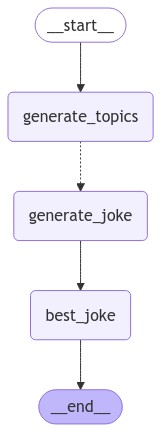

In [42]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [43]:
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['cat', 'dog', 'lion', 'giraffe']}}
output:  content="Here's a joke about cats:\n\nWhy did the cat go to the computer programming session? Because he wanted to learn some new mouse clicks!" additional_kwargs={'usage': {'prompt_tokens': 19, 'completion_tokens': 32, 'total_tokens': 51}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 19, 'completion_tokens': 32, 'total_tokens': 51}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-579d536a-e960-4905-af4a-8e802c172583-0' usage_metadata={'input_tokens': 19, 'output_tokens': 32, 'total_tokens': 51}
output:  content="Here's a joke about a dog:\n\nWhy did the dog cross the road twice? Because he was a double-crosser!" additional_kwargs={'usage': {'prompt_tokens': 19, 'completion_tokens': 30, 'total_tokens': 49}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'